# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
!pip install --upgrade pip
!pip install -r ../../requirements.txt
!pip install opencv-python-headless

     |████████████████████████████████| 1.5MB 889kB/s eta 0:00:01
  Found existing installation: pip 19.1
    Uninstalling pip-19.1:
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/bin/pip3'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 26.0MB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 2.0MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 26.2MB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 952kB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 3.1MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |██████████████████████████

     |████████████████████████████████| 2.8MB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 204kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 163kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 92kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 8.8MB 592kB/s eta 0:00:011
     |████████████████████████████████| 122kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 102kB 3.6MB/s ta 0:00:011
     |████████████████████████████████| 40kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 2.7MB/s ta 0:00:01
     |████████████████████████████████| 102kB 3.4MB/s ta 0:00:01
     |████████████████████████████████| 552kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 92kB 2.8MB/s eta 0:00:011


     |████████████████████████████████| 61kB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 143kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 184kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 163kB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 2.5MB/s eta 0:00:01
Failed to build pycocotools opencv-python
Failed to build pyyaml
ERROR: Could not build wheels for pycocotools, opencv-python which use PEP 517 and cannot be installed directly
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 88.9MB 2.9MB/s eta 0:00:01     |███████████████████████▍        | 64.9MB 3.3MB/s eta 0:00:08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Failed to build opencv-python-headless
ERROR: Could not build wheels for opencv-python-headless which use PEP 517 and cannot be installed directly
You should co

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import skimage
import json
import wandb

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#tf.keras.backend.set_session(tf.Session(config=config));

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
importlib.reload(modellib)
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

ImportError: No module named 'cv2'

## Configurations

In [3]:
class IEConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "InteractiveElements"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 interactive element types

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
    EPOCHS = 10 
    LAYERS = "head"
    
    INIT_WITH = "coco"  # imagenet, coco, or last
    
config = IEConfig()
config.display()

NameError: name 'Config' is not defined

## Wandb

In [ ]:
wandb.init(project="Test", entity="bmeyjohann", sync_tensorboard=True)

wandb.config = {
    "learning_rate": config.LEARNING_RATE,
    "learning_momentum": config.LEARNING_MOMENTUM,
    "epochs": config.EPOCHS,
    "batch_size": config.BATCH_SIZE,
    "image_min_dim": IMAGE_MIN_DIM,
    "image_max_dim": IMAGE_MAX_DIM,
    "init_with": config.INIT_WITH
}

## Notebook Preferences

In [12]:
def get_ax(rows=1, cols=1, size=1):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [13]:
classes = ["Filled.Menu", "Filled.ArrowBack", "MoreOptions", "FloatingActionButton",
           "NavigationBarItem", "Button"]

class IEDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_ie(self, dataset_dir, subset):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        for i in range(len(classes)):
            self.add_class("InteractiveElements", i, classes[i])
            
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        # get size of one image since all should have the same size
        image_path = os.path.join(dataset_dir, "0.png")
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        
        file_index = 0
        # for every json file since there is one json file for each image
        while os.path.isfile(os.path.join(dataset_dir,str(file_index) + ".json")):
            with open(os.path.join(dataset_dir,str(file_index) + ".json")) as annotation_file:
                annotations = json.load(annotation_file)
                
                ids = []
                # for every interactive element in an image that shall be recognized
                for i in range(len(annotations.values())):
                    ids.append(self.get_index_of_class(annotations[str(i)]["class"]))
                
                self.add_image(
                    "InteractiveElements",
                    image_id=file_index,
                    path=os.path.join(dataset_dir, str(file_index)),
                    width=width, height=height,
                    num_ids=ids)
                
            file_index = file_index + 1
        
    def get_index_of_class(self, class_of_element):
        for i in range(len(classes)):
            if class_of_element == classes[i]:
                return i + 1
        raise ValueError("Could not find index of class " + class_of_element)

    def load_image(self, image_id):
        """Return image from image id.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        image = skimage.io.imread(image_path + ".png")
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "InteractiveElements":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        num_of_masks = len(info["num_ids"])
        
        masks = np.zeros([info['height'], info['width'], num_of_masks], dtype=np.bool)
        
        for mask_index in range(num_of_masks):
            image = skimage.io.imread(image_path + "_" + str(mask_index) + ".png")
            masks[:, :, mask_index:mask_index+1] = image[:, :, 0:1].astype(np.bool)
        
        return np.invert(masks), np.array(info["num_ids"])

In [14]:
PATH_OF_DATASET = "dataset/"

# Training dataset
dataset_train = IEDataset()
dataset_train.load_ie(PATH_OF_DATASET, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = IEDataset()
dataset_val.load_ie(PATH_OF_DATASET, "val")
dataset_val.prepare()

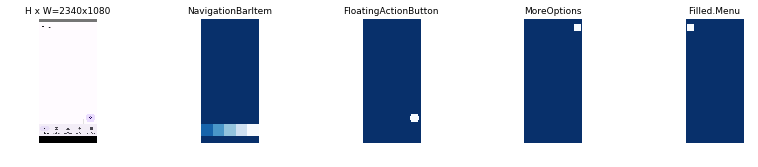

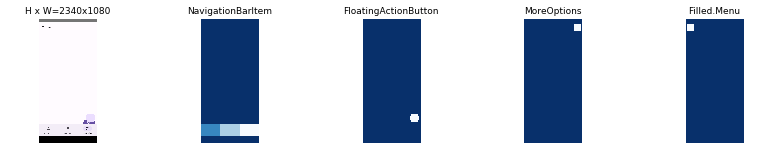

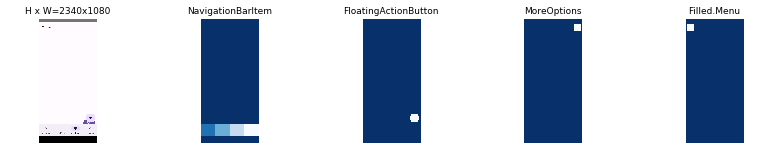

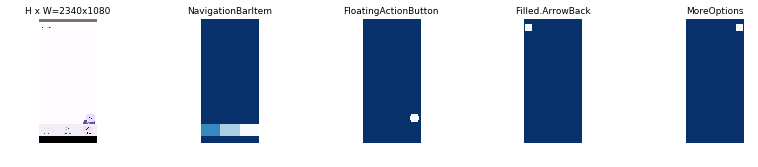

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [17]:
# Which weights to start with?

if config.INIT_WITH == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif config.INIT_WITH == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif config.INIT_WITH == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [18]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
config.EPOCHS=10
config.LAYERS='heads'

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers=config.LAYERS)


Starting at epoch 0. LR=0.001

Checkpoint Path: /tf/notebooks/logs/interactiveelements20220708T1135/mask_rcnn_interactiveelements_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 321s - loss: 0.4286 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1224 - val_loss: 0.1389 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.0247 - val_mrcnn_class_loss: 0.0380 - val_mrcnn_bbox_loss: 0.0204 - val_mrcnn_mask_loss: 0.0531
Epoch 2/10
1000/1000 [==============================] - 233s - loss: 0.1522 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0465 - val_loss: 0.1030 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.0206 - val_mrcnn_class_loss: 0.0279 - val_mrcnn_bbox_loss: 0.0123 - val_mrcnn_mask_loss: 0.0408
Epoch 3/10
1000/1000 [==============================] - 233s - loss: 0.1312 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0388 - val_loss: 0.1126 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_lo

In [20]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
config.EPOCHS=10
config.LAYERS="all"

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=config.EPOCHS, 
            layers=config.LAYERS)


Starting at epoch 10. LR=0.0001

Checkpoint Path: /tf/notebooks/logs/interactiveelements20220708T1135/mask_rcnn_interactiveelements_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

In [21]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [22]:
class InferenceConfig(IEConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /tf/notebooks/logs/interactiveelements20220708T1135/mask_rcnn_interactiveelements_0009.h5
Re-starting from epoch 9


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 2340.00000  float64
gt_class_id              shape: (9,)                  min:    2.00000  max:    6.00000  int64
gt_bbox                  shape: (9, 4)                min:   20.00000  max:  483.00000  int32
gt_mask                  shape: (512, 512, 9)         min:    0.00000  max:    1.00000  bool


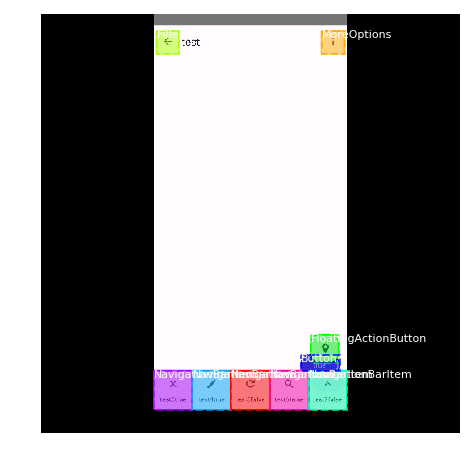

In [43]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


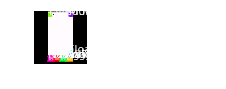

In [24]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [46]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


In [ ]:
wandb.finish()